In [107]:
import torch
import copy
import umap
import argparse
import numpy as np
from numpy import genfromtxt
import difflib
import matplotlib
import networkx as nx
import community
import seaborn as sns; sns.set()
from matplotlib import colors
from matplotlib import pyplot as plt
%matplotlib inline

### Setting plot parameters

In [108]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 24

greens = plt.get_cmap('Greens')
purples = plt.get_cmap('Purples')
greys = plt.get_cmap('Greys')
plt.rc('lines',linewidth=2)
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE - 4, frameon=False)    # legend fontsize
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
plt.rcParams.update({'axes.spines.top': False, 'axes.spines.right': False})

sns.set_style(style='white')

### Specify parameters

In [18]:
device = torch.device('cpu')
N = 100 # No. of input nodes i.e. behaviours
R = 2 # No. of descending neurons i.e. bottleneck layer
M = N # No. of motor units, output
n = 10 # No. of responding output nodes
fn = n/M # Fraction of output nodes that are responding
response_threshold = 0.5 # Whether an input corresponds to activating the node or not
loss_series = []

In [67]:
R_list = [5, 7, 8, 10, 12, 14, 16, 20, 25, 30, 40, 50]
noise = [0, 1, 3, 5, 8]

* noise 8 modularity = 0.18
* 5 = 0.24
* 3 = 0.46
* 1 = 0.68
* 0 = 0.80

### Generate input matrix (identity)

In [20]:
x_in = [[1 if i==j else 0 for i in range(N)] for j in range(N)]
x = torch.tensor(x_in).float()

### Defining useful functions

In [22]:
# Activation function
def actfn(x):
    y = x.sigmoid()
    return y

In [33]:
def load_epistasis (i, j, k):
    device = 'cpu'
    # i= {0} = R, hidden_layer, j = {1} = noise, k = {2} = disorder sample
    b1 =  torch.tensor(np.loadtxt('/Users/ravasio/Documents/Boulder_2019/Anjalika/parameters_boulder_270420/bias1_5.0_{}_10_{}_{}.dat'.format(i, j, k)), dtype=torch.float32, device=device)
    b2 =  torch.tensor(np.loadtxt('/Users/ravasio/Documents/Boulder_2019/Anjalika/parameters_boulder_270420/bias2_5.0_{}_10_{}_{}.dat'.format(i, j, k)), dtype=torch.float32, device=device)
    w1 =  torch.tensor(np.loadtxt('/Users/ravasio/Documents/Boulder_2019/Anjalika/parameters_boulder_270420/weights1_5.0_{}_10_{}_{}.dat'.format(i, j, k)), dtype=torch.float32, device=device)
    w2 =  torch.tensor(np.loadtxt('/Users/ravasio/Documents/Boulder_2019/Anjalika/parameters_boulder_270420/weights2_5.0_{}_10_{}_{}.dat'.format(i, j, k)), dtype=torch.float32, device=device)

    return b1, b2, w1, w2

In [30]:
def prediction (x, b1, b2, w1, w2):
    y_pred = actfn(actfn(x.mm(w1)+b1).mm(w2)+b2)
    y_pred_binary = np.abs(np.round(y_pred.data.numpy()))
    
    return y_pred_binary

### Context dependency

In [ ]:
# Adding an activated unit
activated_units = 1
x_act = torch.zeros((N,N+activated_units))
for i in range(len(x)):
    x_act[i] = torch.cat((x[i],torch.ones(activated_units,dtype=torch.float32)))

In [31]:
def affect (R, N, activated_units, b1, b2, w1, w2, y_pred_binary):

    motor_units = [[] for i in range(len(y_pred_binary))] # Which hidden neurons affect each motor unit
    hidden_affected = np.zeros(R) # No. of behaviours affected by each hidden neuron

    for i in range(R):
        activated_hidden = torch.zeros(R)
        activated_hidden[i] = 1000
    
        w_act = torch.zeros((N+activated_units, R))
        for j in range(len(w_act)):
            if j < N:
                w_act[j] = w1[j]
            else:
                w_act[j] = activated_hidden
            
        # Modified predictions of the NN
        y_pred_2 = actfn(actfn(x_act.mm(w_act)+b1).mm(w2)+b2)
        y_pred_2 = y_pred_2.detach().numpy()
        y_pred_2 = np.abs(np.round(y_pred_2))  # Threshold = 0.5
    
        # Explicit comparison of the two outputs
        cmap = colors.ListedColormap(['white','red','yellow','grey'])
        # white: Neuron stays off 
        # red: Neuron is turned off
        # Yellow: Neuron is turned on
        # grey: Neuron stays on
        bounds = [0,0.9,1.9,2.9,3.1]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        comparison_array = (y_pred_2)*2 + y_pred_binary
    
        for k in range(len(comparison_array)):
            for indx, comp in enumerate(comparison_array[k]):
                if comp == 1 or comp == 2:
                    motor_units[indx].append(i+1)
                    
        # Number of behaviours each hidden neuron affects
        for k in range(len(comparison_array)):
            for indx, comp in enumerate(comparison_array[k]):
                if comp == 1 or comp == 2:
                    hidden_affected[i] += 1
                    break
    
        for units in range(len(motor_units)):
            motor_units[units] = list(set(motor_units[units]))
        
        #fig, ax = plt.subplots(figsize=(6,6))
        #ax.imshow(comparison_array, cmap=cmap, norm=norm)
        #plt.xlabel('Motor units')
        #plt.ylabel('Behaviours')
        #plt.title('Compared output: Hidden neuron {} activated'.format(i+1))   
        #plt.savefig('contextdep1.png')

    avg_affected_behaviours = sum(hidden_affected)/R
    return avg_affected_behaviours

In [117]:
def affected_mean (R_list, affected_bhv_list):

    bhv_mean = np.zeros(len(R_list))
    bhv_std = np.zeros(len(R_list))

    for i in range(len(R_list)):
        bhv_mean[i] = np.mean(np.array(affected_bhv_list[i]))
        bhv_std[i] = np.std(np.array(affected_bhv_list[i]))
    return bhv_mean, bhv_std

(-1, 105)

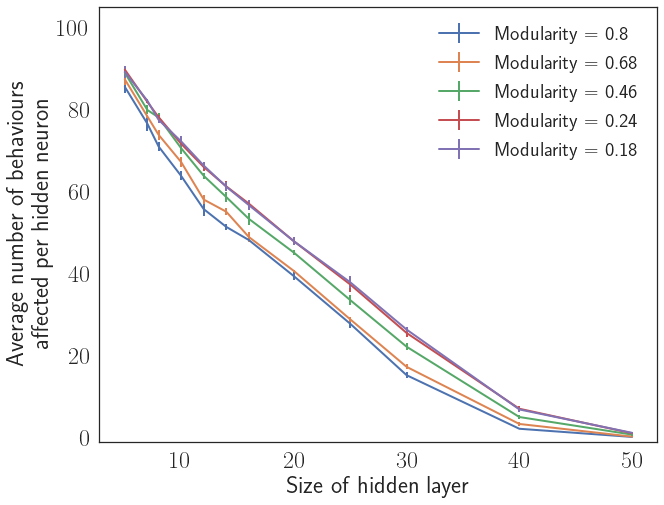

In [120]:
modularity = [0.80, 0.68, 0.46, 0.24, 0.18]

plt.figure(figsize=(10,8))

for j in range(len(noise)):
    n = noise[j]
    affected_bhv_list = []
    
    for i in range(len(R_list)):
        R = R_list[i]
        tmp = []
        
        for index in range(1,6):
            b1, b2, w1, w2 = load_epistasis (float(R), n, index)
            y_pred_binary = prediction (x, b1, b2, w1.T, w2.T)
            avg_affected_behaviours = affect (R, N, activated_units, b1, b2, w1.T, w2.T, y_pred_binary)
            tmp.append(avg_affected_behaviours)
        affected_bhv_list.append(tmp)
        
    bhv_mean, bhv_std = affected_mean(R_list, affected_bhv_list)
    
    plt.errorbar(np.array(R_list), bhv_mean, bhv_std, label = 'Modularity = {}'.format(modularity[j]))

plt.xlabel('Size of hidden layer')
plt.ylabel('Average number of behaviours \n affected per hidden neuron')
plt.legend()
plt.ylim(-1,105)

        
    